<a id='Top'></a>

# MultiSurv results by cancer type<a class='tocSkip'></a>

C-index value results for each cancer type of the best MultiSurv model trained on all-cancer data.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch

# Make modules in "src" dir visible
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(os.path.join(project_dir, 'src'))

import dataset
from model import Model
import utils

matplotlib.style.use('multisurv.mplstyle')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-model" data-toc-modified-id="Load-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load model</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Evaluate</a></span></li><li><span><a href="#Result-graph" data-toc-modified-id="Result-graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Result graph</a></span><ul class="toc-item"><li><span><a href="#Save-to-files" data-toc-modified-id="Save-to-files-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Save to files</a></span></li></ul></li><li><span><a href="#Metric-correlation-with-other-attributes" data-toc-modified-id="Metric-correlation-with-other-attributes-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Metric correlation with other attributes</a></span><ul class="toc-item"><li><span><a href="#Collect-feature-representations" data-toc-modified-id="Collect-feature-representations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Collect feature representations</a></span></li><li><span><a href="#Compute-dispersion-and-add-to-selected-metric-table" data-toc-modified-id="Compute-dispersion-and-add-to-selected-metric-table-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Compute dispersion and add to selected metric table</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Plot</a></span></li></ul></li></ul></div>

In [3]:
DATA = utils.INPUT_DATA_DIR
MODELS = utils.TRAINED_MODEL_DIR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load model

In [29]:
cancers = ['TCGA-SARC', 'TCGA-LUSC', 'TCGA-OV']

labels = pd.read_csv('/app/data/labels.tsv', sep='\t')
print(labels.head(3))

# List of patients to exclude: patients with cancers that are not in the subset
exclude_cancers = list(labels.loc[labels['project_id'].isin(cancers), 'submitter_id'])
len(exclude_cancers)

   submitter_id project_id      time  event  group
0  TCGA-Z7-A8R6  TCGA-BRCA  8.920548      0  train
1  TCGA-C8-A1HE  TCGA-BRCA  1.027397      0  train
2  TCGA-A8-A07B  TCGA-BRCA  3.583562      0  train


1341

In [4]:
dataloaders = utils.get_dataloaders(
    data_location=DATA,
    labels_file='/app/data/labels.tsv',
    modalities=['clinical', 'mRNA'],
     #exclude_patients=exclude_cancers,
    return_patient_id=True
)

Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 1101

Batch size: 128


In [5]:
multisurv = Model(dataloaders=dataloaders, device=device)
multisurv.load_weights(os.path.join(MODELS, 'clinical_mRNA_lr0.005-no-SARC-LUSC-OV_no-pretrained-weights_epoch25_concord0.82.pth'))

Instantiating MultiSurv model...
Load model weights:
/mnt/data/multisurv_models/clinical_mRNA_lr0.005-no-SARC-LUSC-OV_no-pretrained-weights_epoch25_concord0.82.pth


/app/src/model.py:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


# Evaluate

In [6]:
def get_patients_with(cancer_type, split_group='test'):
    labels = pd.read_csv('/app/data/labels.tsv', sep='\t')
    cancer_labels = labels[labels['project_id'] == cancer_type]
    group_cancer_labels = cancer_labels[cancer_labels['group'] == split_group]

    return list(group_cancer_labels['submitter_id'])

In [7]:
%%time

results = {}
minimum_n_patients = 0

cancer_types = pd.read_csv('/app/data/labels.tsv', sep='\t').project_id.unique()

for i, cancer_type in enumerate(cancer_types):
    print('-' * 44)
    print(' ' * 17, f'{i + 1}.', cancer_type)
    print('-' * 44)

    patients = get_patients_with(cancer_type)
    if len(patients) < minimum_n_patients:
        continue
    
    exclude_patients = [p for p in dataloaders['test'].dataset.patient_ids
                        if not p in patients]

    data = utils.get_dataloaders(
        data_location=DATA,
        labels_file='/app/data/labels.tsv',
        modalities=['clinical', 'mRNA'],
        exclude_patients=exclude_patients,
        return_patient_id=True
    )['test'].dataset

    results[cancer_type] = utils.Evaluation(model=multisurv, dataset=data, device=device)
    results[cancer_type].run_bootstrap()
    print()
print()
print()

--------------------------------------------
                  1. TCGA-BRCA
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 109 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 109

Batch size: 128
Collect patient predictions: 109/109

Bootstrap
---------
1000/1000

--------------------------------------------
                  2. TCGA-UCEC
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 55 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 55

Batch size: 128
Collect patient predictions: 55/55

Bootstrap
---------
1000/1000

--------------------------------------------
                  3. TCGA-CHOL
--------------------------------

/app/src/evaluation.py:340: UserWarning: Skipped 76 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 9 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 9

Batch size: 128
Collect patient predictions: 9/9

Bootstrap
---------
1000/1000

--------------------------------------------
                  5. TCGA-DLBC
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 5 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 5

Batch size: 128
Collect patient predictions: 3/5

/app/src/evaluation.py:340: UserWarning: Skipped 33 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Collect patient predictions: 5/5

Bootstrap
---------
1000/1000

--------------------------------------------
                  6. TCGA-CESC
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.


/app/src/evaluation.py:340: UserWarning: Skipped 572 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Keeping 1102 patient(s) not in exclude list.
Keeping 30 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 30

Batch size: 128
Collect patient predictions: 30/30

Bootstrap
---------
1000/1000

--------------------------------------------
                  7. TCGA-ESCA
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 19 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 19

Batch size: 128
Collect patient predictions: 1/19

/app/src/evaluation.py:340: UserWarning: Skipped 1 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Collect patient predictions: 19/19

Bootstrap
---------
1000/1000

--------------------------------------------
                  8. TCGA-KICH
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 11 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 11

Batch size: 128
Collect patient predictions: 11/11

Bootstrap
---------
1000/1000

--------------------------------------------
                  9. TCGA-HNSC
--------------------------------------------


/app/src/evaluation.py:340: UserWarning: Skipped 365 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 52 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 52

Batch size: 128
Collect patient predictions: 52/52

Bootstrap
---------
1000/1000

--------------------------------------------
                  10. TCGA-COAD
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 46 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 46

Batch size: 128
Collect patient predictions: 46/46

Bootstrap
---------
1000/1000

--------------------------------------------
                  11. TCGA-BLCA
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 41 patient(s

/app/src/evaluation.py:340: UserWarning: Skipped 22 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Keeping 1102 patient(s) not in exclude list.
Keeping 59 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 59

Batch size: 128
Collect patient predictions: 59/59

Bootstrap
---------
1000/1000

--------------------------------------------
                  14. TCGA-MESO
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 8 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 8

Batch size: 128
Collect patient predictions: 8/8

Bootstrap
---------
1000/1000

--------------------------------------------
                  15. TCGA-SARC
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 26 patient(s) not in exclude list.
Data modalities:
   clinic

/app/src/evaluation.py:340: UserWarning: Skipped 619 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Collect patient predictions: 17/17

Bootstrap
---------
1000/1000

--------------------------------------------
                  18. TCGA-LUAD
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 52 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 52

Batch size: 128
Collect patient predictions: 1/52

/app/src/evaluation.py:340: UserWarning: Skipped 45 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Collect patient predictions: 52/52

Bootstrap
---------
1000/1000

--------------------------------------------
                  19. TCGA-LUSC
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 49 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 49

Batch size: 128
Collect patient predictions: 49/49

Bootstrap
---------
1000/1000

--------------------------------------------
                  20. TCGA-PAAD
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 18 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 18

Batch size: 128
Collect patient predictions: 18/18

Bootstrap
---------
1000/1000

-------------------------------------------

/app/src/evaluation.py:340: UserWarning: Skipped 353 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Collect patient predictions: 44/44

Bootstrap
---------
1000/1000

--------------------------------------------
                  27. TCGA-OV
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 58 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 58

Batch size: 128
Collect patient predictions: 58/58

Bootstrap
---------
1000/1000

--------------------------------------------
                  28. TCGA-THYM
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 12 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 12

Batch size: 128
Collect patient predictions: 12/12

Bootstrap
---------
1000/1000

--------------------------------------------


/app/src/evaluation.py:340: UserWarning: Skipped 347 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 6 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 6

Batch size: 128
Collect patient predictions: 6/6

Bootstrap
---------
1000/1000

--------------------------------------------
                  30. TCGA-UVM
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 7 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 7

Batch size: 128
Collect patient predictions: 7/7

Bootstrap
---------
1000/1000

--------------------------------------------
                  31. TCGA-TGCT
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 25 patient(s) not in 

/app/src/evaluation.py:340: UserWarning: Skipped 24 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Collect patient predictions: 25/25

Bootstrap
---------
1000/1000

--------------------------------------------
                  32. TCGA-THCA
--------------------------------------------
Keeping 8808 patient(s) not in exclude list.
Keeping 1102 patient(s) not in exclude list.
Keeping 51 patient(s) not in exclude list.
Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 51

Batch size: 128
Collect patient predictions: 1/51

/app/src/evaluation.py:340: UserWarning: Skipped 357 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


Collect patient predictions: 51/51

Bootstrap
---------
1000/1000



CPU times: user 4min 21s, sys: 56.4 s, total: 5min 17s
Wall time: 3min 8s


/app/src/evaluation.py:340: UserWarning: Skipped 113 bootstraps (No admissable pairs in the dataset.).
  warnings.warn(


In [8]:
len(cancer_types)

32

In [9]:
%%time

data = utils.get_dataloaders(
    data_location=DATA,
    labels_file='/app/data/labels.tsv',
    modalities=['clinical', 'mRNA'],
    return_patient_id=True
)['test'].dataset

results['All'] = utils.Evaluation(model=multisurv, dataset=data, device=device)
results['All'].run_bootstrap()
print()

Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8808
   val: 1102
   test: 1101

Batch size: 128
Collect patient predictions: 1101/1101

Bootstrap
---------
1000/1000

CPU times: user 2min 5s, sys: 28.7 s, total: 2min 34s
Wall time: 1min 52s


In order to avoid very __noisy values__, establish a __minimum threshold__ for the number of patients in each given cancer type.

In [10]:
minimum_n_patients = 20

In [11]:
cancer_types = pd.read_csv('/app/data/labels.tsv', sep='\t').project_id.unique()
selected_cancer_types = ['All']

print('-' * 40)
print(' Cancer     Ctd      IBS     # patients')
print('-' * 40)
for cancer_type in sorted(list(cancer_types)):
    patients = get_patients_with(cancer_type)
    if len(patients) > minimum_n_patients:
        selected_cancer_types.append(cancer_type)
        ctd = str(round(results[cancer_type].c_index_td, 3))
        ibs = str(round(results[cancer_type].ibs, 3))

        message = '  ' + cancer_type[5:]
        message += ' ' * (11 - len(message)) + ctd
        message += ' ' * (20 - len(message)) + ibs
        message += ' ' * (32 - len(message)) + str(len(patients))
        print(message)
#         print(' ' + cancer_type + ' ' * (10 - len(cancer_type)) + \
#               ctd + ' ' * (10 - len(ibs)) + ibs + ' ' * (13 - len(ctd)) \
#               + str(len(patients)))

----------------------------------------
 Cancer     Ctd      IBS     # patients
----------------------------------------
  BLCA     0.724    0.214       41
  BRCA     0.867    0.173       109
  CESC     0.716    0.168       30
  COAD     0.787    0.145       46
  GBM      0.694    0.149       59
  HNSC     0.705    0.15        52
  KIRC     0.907    0.101       54
  KIRP     0.941    0.097       29
  LGG      0.906    0.102       52
  LIHC     0.82     0.13        38
  LUAD     0.783    0.163       52
  LUSC     0.613    0.197       49
  OV       0.509    0.231       58
  PRAD     0.219    0.042       50
  SARC     0.457    0.291       26
  SKCM     0.727    0.161       46
  STAD     0.761    0.155       44
  TGCT     0.913    0.035       25
  THCA     0.95     0.062       51
  UCEC     0.747    0.104       55


In [12]:
def format_bootstrap_output(evaluator):
    results = evaluator.format_results()
    
    for metric in results:
        results[metric] = results[metric].split(' ')
        val = results[metric][0]
        ci_low, ci_high = results[metric][1].split('(')[1].split(')')[0].split('-')
        results[metric] = val, ci_low, ci_high
        results[metric] = [float(x) for x in results[metric]]
    
    return results

In [13]:
formatted_results = {}

# for cancer_type in results:
for cancer_type in sorted(selected_cancer_types):
    formatted_results[cancer_type] = format_bootstrap_output(results[cancer_type])

In [14]:
def remove_tcga_prefix(formatted_results):
    """
    Remove 'TCGA-' prefix from cancer type names in the results dictionary.
    
    Args:
        formatted_results: Dictionary with cancer types as keys
        
    Returns:
        Dictionary with 'TCGA-' prefix removed from keys
    """
    cleaned_results = {}
    
    for cancer_type, metrics in formatted_results.items():
        # Remove 'TCGA-' prefix if it exists, otherwise keep the original key
        if cancer_type.startswith('TCGA-'):
            new_key = cancer_type.replace('TCGA-', '')
        else:
            new_key = cancer_type  # Keep 'All' and other non-TCGA keys unchanged
        
        cleaned_results[new_key] = metrics
    
    return cleaned_results

# Alternative one-liner using dictionary comprehension
def remove_tcga_prefix_oneliner(formatted_results):
    """One-liner version using dictionary comprehension."""
    return {
        key.replace('TCGA-', '') if key.startswith('TCGA-') else key: value 
        for key, value in formatted_results.items()
    }
    
formatted_results = remove_tcga_prefix(formatted_results)

In [15]:
formatted_results

{'All': {'C-index': [0.821, 0.805, 0.836],
  'Ctd': [0.821, 0.805, 0.836],
  'IBS': [0.146, 0.13, 0.162],
  'INBLL': [0.459, 0.404, 0.511]},
 'BLCA': {'C-index': [0.724, 0.647, 0.81],
  'Ctd': [0.724, 0.647, 0.81],
  'IBS': [0.214, 0.171, 0.253],
  'INBLL': [0.617, 0.512, 0.707]},
 'BRCA': {'C-index': [0.875, 0.762, 0.972],
  'Ctd': [0.867, 0.753, 0.96],
  'IBS': [0.173, 0.07, 0.197],
  'INBLL': [0.506, 0.237, 0.569]},
 'CESC': {'C-index': [0.724, 0.441, 0.95],
  'Ctd': [0.716, 0.423, 0.95],
  'IBS': [0.168, 0.08, 0.224],
  'INBLL': [0.505, 0.275, 0.653]},
 'COAD': {'C-index': [0.786, 0.644, 0.895],
  'Ctd': [0.787, 0.651, 0.897],
  'IBS': [0.145, 0.07, 0.178],
  'INBLL': [0.443, 0.235, 0.528]},
 'GBM': {'C-index': [0.694, 0.627, 0.771],
  'Ctd': [0.694, 0.627, 0.771],
  'IBS': [0.149, 0.138, 0.213],
  'INBLL': [0.464, 0.437, 0.616]},
 'HNSC': {'C-index': [0.705, 0.608, 0.798],
  'Ctd': [0.705, 0.609, 0.798],
  'IBS': [0.15, 0.125, 0.19],
  'INBLL': [0.47, 0.414, 0.554]},
 'KIRC': {'C-

# Result graph

Exclude cancer types with less than a chosen minimum number of patients, to avoid extremely noisy results.

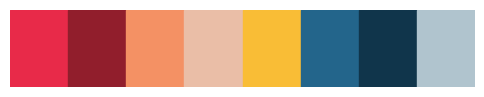

In [16]:
utils.plot.show_default_colors()

In [17]:
PLOT_SIZE = (15, 4)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [18]:
def get_metric_results(metric, data):
    df = pd.DataFrame()
    df['Cancer type'] = data.keys()

    val, err = [], []
    
    for cancer in formatted_results:
        values = formatted_results[cancer][metric]
        val.append(values[0])
        err.append((values[0] - values[1], values[2] - values[0]))

    df[metric] = val
    err = np.swapaxes(np.array(err), 1, 0)

    return df, err

In [19]:
def plot_results(metric, data, ci, y_lim=None, y_label=None, h_lines=[1, 0.5]):
    fig = plt.figure(figsize=PLOT_SIZE)
    ax = fig.add_subplot(1, 1, 1)
    for y in h_lines:
        ax.axhline(y, linestyle='--', color='grey')

    ax.bar(df['Cancer type'][:1], df[metric][:1], yerr=err[:, :1],
           align='center', ecolor=default_colors[0],
           alpha=0.5, capsize=5)
    ax.bar(df['Cancer type'][1:], df[metric][1:], yerr=err[:, 1:],
           align='center', color=default_colors[6], ecolor=default_colors[6],
           alpha=0.5, capsize=5)
    if y_lim is None:
        y_lim = (0, 1)
        
    ax.set_ylim(y_lim)
    ax.set_title('')
    ax.set_xlabel('Cancer types')
    if y_label is None:
        ax.set_ylabel(metric + ' (95% CI)')
    else:
        ax.set_ylabel(y_label)

    return fig

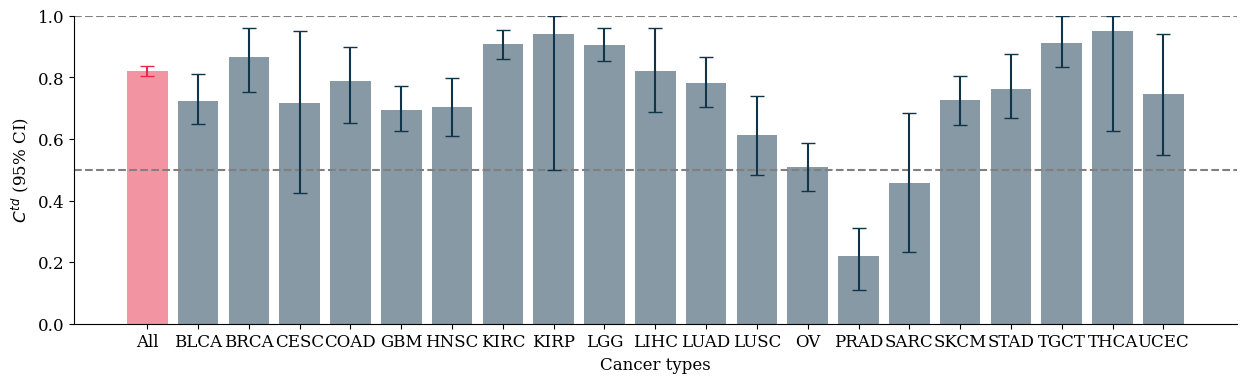

In [20]:
metric='Ctd'

df, err = get_metric_results(metric, formatted_results)
fig_ctd = plot_results(metric, df, err, y_label='$C^{td}$ (95% CI)')

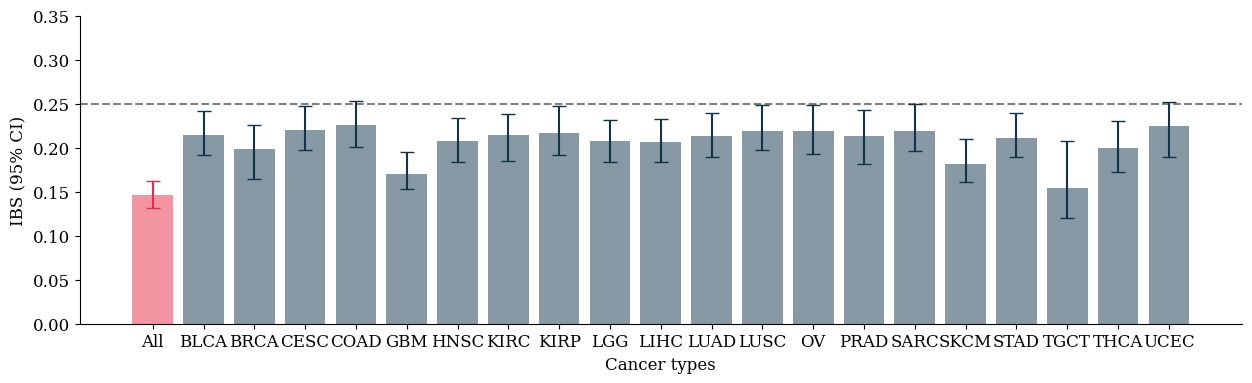

In [47]:
metric='IBS'

df, err = get_metric_results(metric, formatted_results)
fig_ibs = plot_results(metric, df, err, y_lim=(0, 0.35), y_label=None, h_lines=[0.25])

## Save to files

In [182]:
%%javascript

IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [183]:
pdf_file = nb_name.split('.ipynb')[0] + '_Ctd'
utils.plot.save_plot_for_figure(figure=fig_ctd, file_name=pdf_file) 

In [184]:
pdf_file = nb_name.split('.ipynb')[0] + '_IBS'
utils.plot.save_plot_for_figure(figure=fig_ibs, file_name=pdf_file) 

In [185]:
pdf_file = nb_name.split('.ipynb')[0] + '_INBLL'
utils.plot.save_plot_for_figure(figure=fig_inbll, file_name=pdf_file) 

# Watermark<a class='tocSkip'></a>

In [19]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

pandas     1.0.1
torch      1.4.0
numpy      1.18.1
matplotlib 3.1.2

CPython 3.6.7
IPython 7.11.1

last updated: Tue Jul 28 2020


[Top of the page](#Top)